# RL - Learning to Run Power Network Assignment 
## DQN Models

Milisa Sithole - 2446396 \
Oriinga Maudu - 2433303 \
Kudzai Realeboga Saurombe - 2503314 \
Tapiwa Chatikobo - 2442335

## Imports

In [1]:
import gymnasium as gym
from gymnasium.spaces import Discrete

import numpy as np
import matplotlib.pyplot as plt

import grid2op
from grid2op import gym_compat
from grid2op.Parameters import Parameters
from grid2op.Action import PlayableAction
from grid2op.Observation import CompleteObservation
from grid2op.Reward import L2RPNReward, N1Reward, CombinedScaledReward

from lightsim2grid import LightSimBackend
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor

from gymnasium.spaces import Discrete, MultiDiscrete, Box

import grid2op
from grid2op.gym_compat import GymEnv, BoxGymObsSpace, DiscreteActSpace, BoxGymActSpace, MultiDiscreteActSpace
from lightsim2grid import LightSimBackend

## Environmnet Setup

In [5]:
# Gymnasium environment wrapper around Grid2Op environment
class Gym2OpEnv(gym.Env):
    def __init__(
            self
    ):
        super().__init__()

        self._backend = LightSimBackend()
        self._env_name = "l2rpn_case14_sandbox"  # DO NOT CHANGE

        action_class = PlayableAction
        observation_class = CompleteObservation
        reward_class = CombinedScaledReward  # Setup further below

        # DO NOT CHANGE Parameters
        # See https://grid2op.readthedocs.io/en/latest/parameters.html
        p = Parameters()
        p.MAX_SUB_CHANGED = 4  # Up to 4 substations can be reconfigured each timestep
        p.MAX_LINE_STATUS_CHANGED = 4  # Up to 4 powerline statuses can be changed each timestep

        # Make grid2op env
        self._g2op_env = grid2op.make(
            self._env_name, backend=self._backend, test=False,
            action_class=action_class, observation_class=observation_class,
            reward_class=reward_class, param=p
        )

        ##########
        # REWARD #
        ##########
        # NOTE: This reward should not be modified when evaluating RL agent
        # See https://grid2op.readthedocs.io/en/latest/reward.html
        cr = self._g2op_env.get_reward_instance()
        cr.addReward("N1", N1Reward(), 1.0)
        cr.addReward("L2RPN", L2RPNReward(), 1.0)
        # reward = N1 + L2RPN
        cr.initialize(self._g2op_env)
        ##########

        self._gym_env = gym_compat.GymEnv(self._g2op_env)

        self.setup_observations()
        self.setup_actions()

        self.observation_space = self._gym_env.observation_space
        self.action_space = self._gym_env.action_space

    def setup_observations(self):
        # TODO: Your code to specify & modify the observation space goes here
        # See Grid2Op 'getting started' notebooks for guidance
        #  - Notebooks: https://github.com/rte-france/Grid2Op/tree/master/getting_started

        # customize observation space
        obs_attr_to_keep = ["rho", "p_or","q_or", "v_or", "a_or", "gen_p","gen_v", "load_p","load_v","topo_vect","line_status"]
        self._gym_env.observation_space.close()
        self._gym_env.observation_space = BoxGymObsSpace(self._g2op_env.observation_space,
                                                         attr_to_keep=obs_attr_to_keep
                                                         )
        
    def setup_actions(self):
        # TODO: Your code to specify & modify the action space goes here
        # See Grid2Op 'getting started' notebooks for guidance
        #  - Notebooks: https://github.com/rte-france/Grid2Op/tree/master/getting_started

        # customize the action space
        act_type = "discrete"


        self._gym_env.action_space.close()
        if act_type == "discrete":
            # user wants a discrete action space
            act_attr_to_keep =  ["set_line_status_simple", "set_bus","redispatch","curtail","set_storage"]
            self._gym_env.action_space = DiscreteActSpace(self._g2op_env.action_space,
                                                          attr_to_keep=act_attr_to_keep)
            self.action_space = Discrete(self._gym_env.action_space.n)
            #print(self.action_space)
        elif act_type == "box":
            # user wants continuous action space
            act_attr_to_keep =  ["redispatch", "set_storage", "curtail"]
            self._gym_env.action_space = BoxGymActSpace(self._g2op_env.action_space,
                                                        attr_to_keep=act_attr_to_keep)
            self.action_space = Box(shape=self._gym_env.action_space.shape,
                                    low=self._gym_env.action_space.low,
                                    high=self._gym_env.action_space.high)
        elif act_type == "multi_discrete":
            # user wants a multi-discrete action space
            act_attr_to_keep = ["one_line_set", "one_sub_set"]
            self._gym_env.action_space = MultiDiscreteActSpace(self._g2op_env.action_space,
                                                               attr_to_keep=act_attr_to_keep)
            self.action_space = MultiDiscrete(self._gym_env.action_space.nvec)
        else:
            raise NotImplementedError(f"action type '{act_type}' is not currently supported.")
    def reset(self, seed=None):
        return self._gym_env.reset(seed=seed, options=None)    

    def step(self, action):
        def normalize_observation(obs):
            # Example min/max values (adjust these based on your environment)
            obs_min = np.zeros_like(obs)
            obs_max = np.ones_like(obs)  # Adjust this based on actual ranges
            
            # Normalize using (value - min) / (max - min)
            normalized_obs = (obs - obs_min) / (obs_max - obs_min)
            # Clip values to be in [0, 1] range
            return np.clip(normalized_obs, 0, 1)
        
        obs, reward, done, info,_ =self._gym_env.step(action)
        return normalize_observation(obs),reward,done,info,_

    def render(self):
        # TODO: Modify for your own required usage
        return self._gym_env.render()

## Reward Tracker

In [6]:
class RewardLogger(BaseCallback):
    def __init__(self, verbose: int = 1):
        super(RewardLogger, self).__init__(verbose)
        self.episode_rewards = []
        self.losses = []

    def _on_step(self) -> bool:
        # Log the reward when an episode ends
        if self.locals["dones"][0]:
            # Retrieve the last episode reward
            episode_reward = self.locals["infos"][0].get("episode", {}).get("r", 0)
            self.episode_rewards.append(episode_reward)
            if self.verbose > 0:
                print(f"Episode Reward: {episode_reward}")

        return True

    def get_rewards(self):
        return np.array(self.episode_rewards)

env = Monitor(Gym2OpEnv())

c:\Users\Oriin\AppData\Local\Programs\Python\Python311\Lib\site-packages\grid2op\gym_compat\discrete_gym_actspace.py:260: UserWarning: The class "DiscreteActSpace" should mainly be used to consider only discrete actions (eg. set_line_status, set_bus or change_bus). Though it is possible to use "redispatch" when building it, be aware that this continuous action will be treated as discrete by splitting it into bins. Consider using the "BoxGymActSpace" for these attributes.
  warnings.warn(
c:\Users\Oriin\AppData\Local\Programs\Python\Python311\Lib\site-packages\grid2op\gym_compat\discrete_gym_actspace.py:260: UserWarning: The class "DiscreteActSpace" should mainly be used to consider only discrete actions (eg. set_line_status, set_bus or change_bus). Though it is possible to use "curtail" when building it, be aware that this continuous action will be treated as discrete by splitting it into bins. Consider using the "BoxGymActSpace" for these attributes.
  warnings.warn(
c:\Users\Oriin\Ap

## Training

In [13]:
reward_and_loss_logger = RewardLogger(verbose=1)

model = DQN("MlpPolicy",env,verbose=1,learning_rate=0.00004)
model.learn(total_timesteps=1000000,callback=reward_and_loss_logger)
model.save("dqn_assignment")

c:\Users\Oriin\AppData\Local\Programs\Python\Python311\Lib\site-packages\grid2op\gym_compat\discrete_gym_actspace.py:260: UserWarning: The class "DiscreteActSpace" should mainly be used to consider only discrete actions (eg. set_line_status, set_bus or change_bus). Though it is possible to use "redispatch" when building it, be aware that this continuous action will be treated as discrete by splitting it into bins. Consider using the "BoxGymActSpace" for these attributes.
  warnings.warn(
c:\Users\Oriin\AppData\Local\Programs\Python\Python311\Lib\site-packages\grid2op\gym_compat\discrete_gym_actspace.py:260: UserWarning: The class "DiscreteActSpace" should mainly be used to consider only discrete actions (eg. set_line_status, set_bus or change_bus). Though it is possible to use "curtail" when building it, be aware that this continuous action will be treated as discrete by splitting it into bins. Consider using the "BoxGymActSpace" for these attributes.
  warnings.warn(
c:\Users\Oriin\Ap

Using cpu device
Wrapping the env in a DummyVecEnv.
Episode Reward: 0.398623
Episode Reward: 0.345513
Episode Reward: -0.5
Episode Reward: 2.070534
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5        |
|    ep_rew_mean      | 0.579    |
|    exploration_rate | 1        |
| time/               |          |
|    episodes         | 4        |
|    fps              | 13       |
|    time_elapsed     | 1        |
|    total_timesteps  | 20       |
----------------------------------
Episode Reward: -0.191831
Episode Reward: 0.351853
Episode Reward: -0.368204
Episode Reward: 0.726904
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.38     |
|    ep_rew_mean      | 0.354    |
|    exploration_rate | 1        |
| time/               |          |
|    episodes         | 8        |
|    fps              | 11       |
|    time_elapsed     | 3        |
|    total_timesteps  | 35       |
---------------

## Plot Training rewards

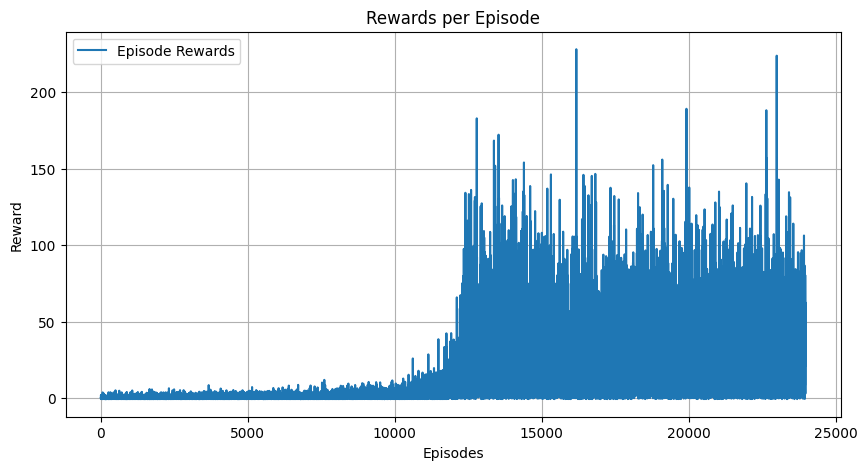

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(reward_and_loss_logger.get_rewards(), label='Episode Rewards')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Rewards per Episode')
plt.legend()
plt.grid()
plt.show()

## Model Evaluation

In [7]:
#del model
model = DQN.load("DQN_saved_models\dqn_v3")

In [21]:
max_steps = 1000

rewards = []
for i in range(100):
        eps_reward = 0
        obs, info = env.reset()
        is_done = False
        curr_step = 0
        while not is_done and curr_step < max_steps:
                action = model.predict(obs)
                obs, reward, terminated, truncated, info = env.step(action[0])

                curr_step += 1
                eps_reward += reward
                is_done = terminated or truncated

        rewards.append(eps_reward)
        
print("Max reward:",np.max(rewards))
print("Total reward:",np.sum(rewards))
print("Average reward:",np.mean(rewards))

Max reward: 83.64308069646358
Total reward: 2614.044731898699
Average reward: 26.14044731898699
